#     Minerva - Modelo Detección Fake News - TEXTOS CORTOS
===============================================================================================================

## 1. Importamos librerías

In [1]:
#General
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#Tratamiento de Texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import SnowballStemmer
from wordcloud import WordCloud, ImageColorGenerator
import string
import re
import spacy

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, datasets
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

#Keras/Tf
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Paquetes que es necesario instalar por primera vez

In [2]:
#pip install --user -U nltk
#nltk.download('wordnet')
#pip install -U spacy
# pip install wordcloud
# !python -m spacy download en_core_web_sm
#!python -m spacy download es

## 2. Importamos dataset

### 2.1. Datasets fake

Los archivos de fake news utilizados en esta ejecución son los siguientes:

* elmundotoday_07072020.csv
* elmundotoday_08072020.csv
* elmundotoday_09072020.csv
* elmundotoday_10072020.csv
* fake_news_10072020.csv
* fake_news_12072020.csv
* fake_news_13072020.csv
* fake_news_14072020.csv
* fake_news_15072020.csv
* fake_news_16072020.csv
* fake_news_17072020.csv
* fake_news_18072020.csv
* extra_fakes_18072020.csv
* fake_news_19072020.csv
* eljueves_19072020.csv
* eljueves_política_19072020
* fake_news_20072020.csv

In [3]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/fake' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_fake = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_fake)

df_fake = pd.concat(li, axis=0, ignore_index=True)

In [4]:
df_fake.head(5)

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
0,0,El Jueves,Abascal desmiente que las chorradas que dice e...,NaN,NaN,NaN,El hackeo masivo de cuentas a famosos y perso...,NaN,https://www.eljueves.es/news/abascal-desmiente...,NaN
1,1,El Jueves,Felipe González se deja de mierdas y se afilia...,NaN,NaN,NaN,"""Estoy hasta los cojones de tanto rojo"", afirm...",NaN,https://www.eljueves.es/news/felipe-gonzalez-s...,NaN
2,2,El Jueves,La Generalitat disfrazará de Colombo a sus ras...,NaN,NaN,NaN,"""Total, tampoco vamos a gastar mucho en disfra...",NaN,https://www.eljueves.es/news/generalitat-disfr...,NaN
3,3,El Jueves,Encuentran a Juan Carlos I abandonado en una g...,NaN,NaN,NaN,"""No sé qué ha sucedido. Estábamos en el coche ...",NaN,https://www.eljueves.es/news/encuentran-juan-c...,NaN
4,4,El Jueves,La encargada de realizar las encuestas del CIS...,NaN,NaN,NaN,El presidente colocó a su abuela en el Institu...,NaN,https://www.eljueves.es/news/encargada-realiza...,NaN


In [5]:
df_fake["Texto"] =df_fake["Texto"].astype(str)

Eliminamos las fake news que figuran como con suscripción y que no son fake news reales

In [6]:
df_fake = df_fake[~df_fake['Texto'].str.contains("Accede a tu cuenta ¡Suscríbete ahora!")]

In [7]:
df_fake.head(10)

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
0,0,El Jueves,Abascal desmiente que las chorradas que dice e...,NaN,NaN,NaN,El hackeo masivo de cuentas a famosos y perso...,NaN,https://www.eljueves.es/news/abascal-desmiente...,NaN
1,1,El Jueves,Felipe González se deja de mierdas y se afilia...,NaN,NaN,NaN,"""Estoy hasta los cojones de tanto rojo"", afirm...",NaN,https://www.eljueves.es/news/felipe-gonzalez-s...,NaN
2,2,El Jueves,La Generalitat disfrazará de Colombo a sus ras...,NaN,NaN,NaN,"""Total, tampoco vamos a gastar mucho en disfra...",NaN,https://www.eljueves.es/news/generalitat-disfr...,NaN
3,3,El Jueves,Encuentran a Juan Carlos I abandonado en una g...,NaN,NaN,NaN,"""No sé qué ha sucedido. Estábamos en el coche ...",NaN,https://www.eljueves.es/news/encuentran-juan-c...,NaN
4,4,El Jueves,La encargada de realizar las encuestas del CIS...,NaN,NaN,NaN,El presidente colocó a su abuela en el Institu...,NaN,https://www.eljueves.es/news/encargada-realiza...,NaN
5,5,El Jueves,Resistiré del Dúo Dinámico se postula como la ...,NaN,NaN,NaN,El caso omiso a las recomendaciones sanitarias...,NaN,https://www.eljueves.es/news/resistire-duo-din...,NaN
6,6,El Jueves,Ana Rosa informa del caso de su marido con la ...,NaN,NaN,NaN,La presentadora defiende el formato de la noti...,NaN,https://www.eljueves.es/news/ana-rosa-informa-...,NaN
7,7,El Jueves,Descubren que la infanta Sofía guardaba la pag...,NaN,NaN,NaN,"""¿Lo que no gustaba era que viajara, ¿no?"" ha ...",NaN,https://www.eljueves.es/news/descubren-que-inf...,NaN
8,8,El Jueves,"Culoking, el helado con sabor a culo de Rey qu...",NaN,NaN,NaN,"""Sabrosísimo"" Francisco Marhuenda Esta mañana ...",NaN,https://www.eljueves.es/news/culoking-helado-s...,NaN
9,9,El Jueves,Trasladarán Galicia a la otra punta del mapa p...,NaN,NaN,NaN,Florentino Pérez se hará cargo de la operación...,NaN,https://www.eljueves.es/news/trasladaran-galic...,NaN


Analizamos los vacíos

In [8]:
df_fake[df_fake["Título"].isnull()]

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
2771,72,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_73
3578,72,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_73
3894,388,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_389
3896,390,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_391
3898,392,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_393
3900,394,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_395
3902,396,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_397
3904,398,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_399
3906,400,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_401
3908,402,Newtral/Fakes,NaN,NaN,NaN,NaN,nan,NaN,NaN,new_403


Eliminamos los vacíos

In [9]:
df_fake = df_fake[df_fake.Título.notnull()]

Comprobamos que ya no hay vacíos

In [10]:
df_fake[df_fake["Texto"].isnull()]

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id


In [11]:
df_fake.head(5)

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
0,0,El Jueves,Abascal desmiente que las chorradas que dice e...,NaN,NaN,NaN,El hackeo masivo de cuentas a famosos y perso...,NaN,https://www.eljueves.es/news/abascal-desmiente...,NaN
1,1,El Jueves,Felipe González se deja de mierdas y se afilia...,NaN,NaN,NaN,"""Estoy hasta los cojones de tanto rojo"", afirm...",NaN,https://www.eljueves.es/news/felipe-gonzalez-s...,NaN
2,2,El Jueves,La Generalitat disfrazará de Colombo a sus ras...,NaN,NaN,NaN,"""Total, tampoco vamos a gastar mucho en disfra...",NaN,https://www.eljueves.es/news/generalitat-disfr...,NaN
3,3,El Jueves,Encuentran a Juan Carlos I abandonado en una g...,NaN,NaN,NaN,"""No sé qué ha sucedido. Estábamos en el coche ...",NaN,https://www.eljueves.es/news/encuentran-juan-c...,NaN
4,4,El Jueves,La encargada de realizar las encuestas del CIS...,NaN,NaN,NaN,El presidente colocó a su abuela en el Institu...,NaN,https://www.eljueves.es/news/encargada-realiza...,NaN


In [12]:
df_fake.shape

(6328, 10)

Analizamos la fuente de las noticias falsas

In [13]:
df_fake["Web"].value_counts()

Newtral/Fakes     3278
El Jueves         2308
El Mundo Today     417
Maldita            240
Newtral/bulos       65
varios              20
Name: Web, dtype: int64

Nos quedamos únicamente con el título de la noticia

In [14]:
df_fake = df_fake[["Título"]]

In [15]:
df_fake.head(5)

,Título
0,Abascal desmiente que las chorradas que dice e...
1,Felipe González se deja de mierdas y se afilia...
2,La Generalitat disfrazará de Colombo a sus ras...
3,Encuentran a Juan Carlos I abandonado en una g...
4,La encargada de realizar las encuestas del CIS...


Analizamos la forma del dataset

In [16]:
df_fake.shape

(6328, 1)

Quitamos duplicados

In [17]:
df_fake = df_fake.drop_duplicates()

In [18]:
df_fake.shape

(3188, 1)

Añadimos un label de que es fake (target=1)

In [19]:
df_fake["Target"] =1

In [20]:
df_fake.head(5)

,Título,Target
0,Abascal desmiente que las chorradas que dice e...,1
1,Felipe González se deja de mierdas y se afilia...,1
2,La Generalitat disfrazará de Colombo a sus ras...,1
3,Encuentran a Juan Carlos I abandonado en una g...,1
4,La encargada de realizar las encuestas del CIS...,1


Renombramos la variable por homogeneidad de notación con el modelo de textos largos

In [21]:
df_fake = df_fake.rename({'Título': 'Texto'}, axis=1)

In [22]:
df_fake.head(5)

,Texto,Target
0,Abascal desmiente que las chorradas que dice e...,1
1,Felipe González se deja de mierdas y se afilia...,1
2,La Generalitat disfrazará de Colombo a sus ras...,1
3,Encuentran a Juan Carlos I abandonado en una g...,1
4,La encargada de realizar las encuestas del CIS...,1


Analizamos si hay textos vacíos

In [23]:
df_fake["Long"] = df_fake["Texto"].str.len()
df_fake["Long"].value_counts()

73     74
75     71
60     67
83     67
78     66
       ..
180     1
176     1
170     1
166     1
2       1
Name: Long, Length: 155, dtype: int64

In [24]:
df_fake[df_fake["Long"]==0]

,Texto,Target,Long


Si los hubiera los eliminamos

In [25]:
df_fake = df_fake[df_fake["Long"]>0]

Guardamos una variable con el tamaño de las fake news que en pasos posteriores utilizaremos

In [26]:
size_fake_news=df_fake.shape[0]
print(size_fake_news)

3188


### 2.2. Datasets reales

Los archivos de noticias reales utilizados para esta ejecución son los siguientes:

* news_completo_07072020
* news_completo_08072020
* news_completo_09072020
* news_completo_10072020
* news_completo_11072020
* news_completo_12072020
* news_completo_12072020
* news_completo_13072020
* news_completo_14072020
* news_completo_15072020
* news_completo_16072020
* news_completo_17072020
* news_completo_18072020
* news_completo_19072020
* news_completo_20072020

Se leen los archivos de la ruta, se leen con pandas y se concatenan

In [27]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/real' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_real = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_real)

df_real = pd.concat(li, axis=0, ignore_index=True)

In [28]:
df_real.head(5)

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha
0,0,new_1,El Confidencial,Marjaliza detalla ante el juez las supuestas m...,Pablo Gabilondo,1,1,07/07/2020 14:14 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
1,1,new_2,El Confidencial,"País Vasco cree que el brote de Ordizia, con 3...",Agencias,0,120,07/07/2020 08:22 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
2,2,new_3,El Confidencial,Ayuso siempre se adelantó: el PP de Madrid vue...,A. Pérez Giménez,0,15,07/07/2020 11:04La presidenta de la Comunidad ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
3,3,new_4,El Confidencial,Sanidad no tiene datos fiables de muertes por ...,EFE,0,6,07/07/2020 09:14 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
4,4,new_5,El Confidencial,Dimite uno de los fichajes de Hernàndez en RTV...,Víctor Romero. Valencia,0,6,07/07/2020 05:00 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07


Analizamos los vacíos

In [29]:
df_real[df_real["Título"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha
947,413,new_414,ABC,NaN,Mónica Arrizabalaga,0,Revisar,Mi cuenta Explora fechas especiales de tu vida...,1,https://www.abc.es/archivo/#vca=antetitulo&vmc...,--
1391,373,new_374,El País,NaN,NaN,0,NaN,NaN,1,NaN,NaN
1442,424,new_425,ABC,NaN,Mónica Arrizabalaga,0,NaN,Mi cuenta Explora fechas especiales de tu vida...,1,https://www.abc.es/archivo/#vca=antetitulo&vmc...,--
2222,565,new_566,Marca,NaN,NaN,0,NaN,NaN,1,NaN,NaN
2803,413,new_414,ABC,NaN,Mónica Arrizabalaga,0,NaN,Mi cuenta Explora fechas especiales de tu vida...,1,https://www.abc.es/archivo/#vca=antetitulo&vmc...,--
2964,574,new_575,Marca,NaN,NaN,0,NaN,NaN,1,NaN,NaN
3680,548,eco_549,El Economista,NaN,"['Vicente Nieves', 'elEconomista ', 'Laura de ...",0,0,La histórica mayoría absoluta de Alberto Núñez...,1,https://www.eleconomista.es/opinion-blogs/noti...,2020-07-13
3681,549,eco_550,El Economista,NaN,"['Vicente Nieves', 'elEconomista ', 'Laura de ...",0,21,El Govern de Quim Torra aprobará por Decreto L...,1,https://www.eleconomista.es/catalunya/noticias...,2020-07-13
4063,931,dep_932,As,NaN,NaN,0,NaN,NaN,1,https://www.lasapuestasdeas.com/aprovecha-una-...,NaN
4064,932,dep_933,As,NaN,NaN,0,NaN,NaN,1,https://www.lasapuestasdeas.com/no-te-pierdas-...,NaN


Eliminamos los vacíos

In [30]:
df_real = df_real[df_real.Título.notnull()]

Comprobamos que ya no hay vacíos

In [31]:
df_real[df_real["Título"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha


Nos quedamos únicamente con el título de la noticia

In [32]:
df_real = df_real[["Título"]]

In [33]:
df_real.head(5)

,Título
0,Marjaliza detalla ante el juez las supuestas m...
1,"País Vasco cree que el brote de Ordizia, con 3..."
2,Ayuso siempre se adelantó: el PP de Madrid vue...
3,Sanidad no tiene datos fiables de muertes por ...
4,Dimite uno de los fichajes de Hernàndez en RTV...


Analizamos la forma del dataset

In [34]:
df_real.shape

(11168, 1)

Quitamos duplicados

In [35]:
df_real = df_real.drop_duplicates()

In [36]:
df_real.shape

(6242, 1)

Añadimos un label de que es noticia real (target=0)

In [37]:
df_real["Target"] =0

In [38]:
df_real.head(5)

,Título,Target
0,Marjaliza detalla ante el juez las supuestas m...,0
1,"País Vasco cree que el brote de Ordizia, con 3...",0
2,Ayuso siempre se adelantó: el PP de Madrid vue...,0
3,Sanidad no tiene datos fiables de muertes por ...,0
4,Dimite uno de los fichajes de Hernàndez en RTV...,0


Renombramos la variable por homogeneidad con el modelo de textos largos

In [39]:
df_real = df_real.rename({'Título': 'Texto'}, axis=1)

In [40]:
df_real.head(10)

,Texto,Target
0,Marjaliza detalla ante el juez las supuestas m...,0
1,"País Vasco cree que el brote de Ordizia, con 3...",0
2,Ayuso siempre se adelantó: el PP de Madrid vue...,0
3,Sanidad no tiene datos fiables de muertes por ...,0
4,Dimite uno de los fichajes de Hernàndez en RTV...,0
5,El acta que incrimina al rey Juan Carlos,0
6,Cs busca un pacto antitránsfugas con PSOE y PP...,0
7,Una mujer se tira desde un balcón por miedo a ...,0
8,El Gobierno planea fuertes restricciones a la ...,0
9,Asturias registra su primer positivo tras 25 d...,0


Analizamos si hay algun texto vacío

In [41]:
df_real["Long"] = df_real["Texto"].str.len()
df_real["Long"].value_counts()

75     139
79     135
67     122
84     120
87     120
      ... 
142      1
154      1
123      1
139      1
165      1
Name: Long, Length: 143, dtype: int64

Si hay algún texto vacío se elimina

In [42]:
df_real = df_real[df_real["Long"]>0]

In [43]:
df_real.shape

(6242, 3)

Dado que el dataset de noticias reales es mayor que el de fake news, en lugar de utilizar todas las noticias reales consideramos una muestra aleatoria de noticias reales con un tamaño similar al que tengamos de fake news (undersampling)

In [44]:
df_real_rand = df_real.sample(n=size_fake_news, replace=False, random_state=42)

In [45]:
df_real_rand.shape

(3188, 3)

### 2.3. Unión de los datasets

In [46]:
df = pd.concat([df_real_rand, df_fake], ignore_index=True)

In [47]:
df.shape

(6376, 3)

In [48]:
df["Target"].value_counts()

1    3188
0    3188
Name: Target, dtype: int64

## 3. Pre-procesado

### 3.1. Transformamos a formato string

In [49]:
df["Texto"] = df["Texto"].astype(str)

### 3.2. Eliminar números

In [50]:
def elimina_numeros(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

In [51]:
df["Texto"] = df["Texto"].apply(lambda x: elimina_numeros(x))

In [52]:
df.head(10)

,Texto,Target,Long
0,Covid-: la segunda oleada llegará y no será po...,0,65
1,"Íñigo Errejón, tras los resultados de las elec...",0,76
2,El Govern aconseja no salir de casa en Barcelo...,0,79
3,Mata de una puñalada a un hombre en Caravaca d...,0,55
4,La verdad sobre el «six pack»: cómo marcar más...,0,62
5,El baile viral de Vinicius en TikTok para cele...,0,68
6,Tres sencillos ejercicios para entrenar la gra...,0,69
7,Duro Felguera podría acudir al fondo de rescat...,0,60
8,Los alimentos con más triptófano y por qué apo...,0,59
9,¿Moretones espontáneos? Podrías tener un probl...,0,65


### 3.3. Transformamos  a minúscula

In [53]:
df["Texto"] = df["Texto"].str.lower()

In [54]:
df.head(10)

,Texto,Target,Long
0,covid-: la segunda oleada llegará y no será po...,0,65
1,"íñigo errejón, tras los resultados de las elec...",0,76
2,el govern aconseja no salir de casa en barcelo...,0,79
3,mata de una puñalada a un hombre en caravaca d...,0,55
4,la verdad sobre el «six pack»: cómo marcar más...,0,62
5,el baile viral de vinicius en tiktok para cele...,0,68
6,tres sencillos ejercicios para entrenar la gra...,0,69
7,duro felguera podría acudir al fondo de rescat...,0,60
8,los alimentos con más triptófano y por qué apo...,0,59
9,¿moretones espontáneos? podrías tener un probl...,0,65


### 3.4. Eliminación de signos de puntuación

In [55]:
#Signos de puntuación
df["Texto"] = df['Texto'].str.replace('[{}]'.format(string.punctuation), '')

#Otros caracteres raros que se encuentren en el texto
df['Texto'] = df['Texto'].str.replace('"', '')
df['Texto'] = df['Texto'].str.replace("\n", '')
df['Texto'] = df['Texto'].str.replace("•", '')
df['Texto'] = df['Texto'].str.replace("“", '')
df['Texto'] = df['Texto'].str.replace( "”", '')
df['Texto'] = df['Texto'].str.replace( '–', '')
df['Texto'] = df['Texto'].str.replace( '«', '')
df['Texto'] = df['Texto'].str.replace( '»', '')
df['Texto'] = df['Texto'].str.replace( '¿', '')
df['Texto'] = df['Texto'].str.replace( '‘', '')
df['Texto'] = df['Texto'].str.replace( '’', '')
df['Texto'] = df['Texto'].str.replace( '¡', '')

In [56]:
df.head(10)

,Texto,Target,Long
0,covid la segunda oleada llegará y no será por ...,0,65
1,íñigo errejón tras los resultados de las elecc...,0,76
2,el govern aconseja no salir de casa en barcelo...,0,79
3,mata de una puñalada a un hombre en caravaca d...,0,55
4,la verdad sobre el six pack cómo marcar más lo...,0,62
5,el baile viral de vinicius en tiktok para cele...,0,68
6,tres sencillos ejercicios para entrenar la gra...,0,69
7,duro felguera podría acudir al fondo de rescat...,0,60
8,los alimentos con más triptófano y por qué apo...,0,59
9,moretones espontáneos podrías tener un problem...,0,65


### 3.5. Eliminamos espacios excesivos

In [57]:
df["Texto"] = df["Texto"].str.split()

In [58]:
df['Texto'] = df['Texto'].apply(lambda x: ','.join(map(str, x)))
df['Texto'] = df['Texto'].str.replace( ",", ' ')

In [59]:
df.head(10)

,Texto,Target,Long
0,covid la segunda oleada llegará y no será por ...,0,65
1,íñigo errejón tras los resultados de las elecc...,0,76
2,el govern aconseja no salir de casa en barcelo...,0,79
3,mata de una puñalada a un hombre en caravaca d...,0,55
4,la verdad sobre el six pack cómo marcar más lo...,0,62
5,el baile viral de vinicius en tiktok para cele...,0,68
6,tres sencillos ejercicios para entrenar la gra...,0,69
7,duro felguera podría acudir al fondo de rescat...,0,60
8,los alimentos con más triptófano y por qué apo...,0,59
9,moretones espontáneos podrías tener un problem...,0,65


### 3.6. Eliminamos posibles URL del texto

In [60]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [61]:
df["Texto"] = df["Texto"].apply(lambda x: remove_URL(x))

In [62]:
df.head(10)

,Texto,Target,Long
0,covid la segunda oleada llegará y no será por ...,0,65
1,íñigo errejón tras los resultados de las elecc...,0,76
2,el govern aconseja no salir de casa en barcelo...,0,79
3,mata de una puñalada a un hombre en caravaca d...,0,55
4,la verdad sobre el six pack cómo marcar más lo...,0,62
5,el baile viral de vinicius en tiktok para cele...,0,68
6,tres sencillos ejercicios para entrenar la gra...,0,69
7,duro felguera podría acudir al fondo de rescat...,0,60
8,los alimentos con más triptófano y por qué apo...,0,59
9,moretones espontáneos podrías tener un problem...,0,65


### 3.7. Eliminamos stopwords

In [63]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [64]:
#Stopwords estándar
stop = stopwords.words('spanish')

#Añadimos las stopwords que consideremos oportuno
stop.extend(["hacia", "tras"])

In [65]:
#Dividimos el texto en lista
df["Texto"] = df["Texto"].str.split()

#Eliminamos stopwords
df['Texto']= df['Texto'].apply(lambda x: [item for item in x if item not in stop])

#Unimos de nuevo la información
df['Texto'] = df['Texto'].apply(lambda x: ','.join(map(str, x)))
df['Texto'] = df['Texto'].str.replace( ",", ' ')

In [66]:
df.head(10)

,Texto,Target,Long
0,covid segunda oleada llegará culpa virus,0,65
1,íñigo errejón resultados elecciones podemos ex...,0,76
2,govern aconseja salir casa barcelona colau afi...,0,79
3,mata puñalada hombre caravaca cruz,0,55
4,verdad six pack cómo marcar abdominales,0,62
5,baile viral vinicius tiktok celebrar título liga,0,68
6,tres sencillos ejercicios entrenar gratitud se...,0,69
7,duro felguera podría acudir fondo rescate gobi...,0,60
8,alimentos triptófano aporta felicidad,0,59
9,moretones espontáneos podrías tener problema c...,0,65


### 3.8. Lematización 

La lematización es un proceso lingüístico que consiste en, dada una forma flexionada, hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Por ejemplo, los términos "cantamos", "cantan", "cantemos", provienen de un lema común que es "cantar". 

Vamos a crear una nueva variable llamada Texto_2 para incoporar este tratamiento y ver si mejora la capacidad predictiva

In [67]:
nlp = spacy.load("es_core_news_sm")

In [68]:
def lematizar(text):
    doc = nlp(text)
    lemmas = [tok.lemma_.lower() for tok in doc]
    return lemmas

In [69]:
df["Texto_2"] = df["Texto"].apply(lambda x: lematizar(x))

In [70]:
df.head(10)

,Texto,Target,Long,Texto_2
0,covid segunda oleada llegará culpa virus,0,65,"[covid, segundar, olear, llegar, culpar, virus]"
1,íñigo errejón resultados elecciones podemos ex...,0,76,"[íñigo, errejón, resultar, elección, poder, ex..."
2,govern aconseja salir casa barcelona colau afi...,0,79,"[govern, aconsejar, salir, casar, barcelona, c..."
3,mata puñalada hombre caravaca cruz,0,55,"[matar, puñalada, hombre, caravaca, cruz]"
4,verdad six pack cómo marcar abdominales,0,62,"[verdad, six, pack, cómo, marcar, abdominal]"
5,baile viral vinicius tiktok celebrar título liga,0,68,"[bailar, viral, vinicius, tiktok, celebrar, tí..."
6,tres sencillos ejercicios entrenar gratitud se...,0,69,"[tres, sencillo, ejercicio, entrenar, gratitud..."
7,duro felguera podría acudir fondo rescate gobi...,0,60,"[durar, felguera, poder, acudir, fondo, rescat..."
8,alimentos triptófano aporta felicidad,0,59,"[alimento, triptófano, aportar, felicidad]"
9,moretones espontáneos podrías tener problema c...,0,65,"[moretón, espontáneo, poder, tener, problema, ..."


In [71]:
df['Texto_2'] = df['Texto_2'].apply(lambda x: ','.join(map(str, x)))
df['Texto_2'] = df['Texto_2'].str.replace( ",", ' ')

In [72]:
df.head(10)

,Texto,Target,Long,Texto_2
0,covid segunda oleada llegará culpa virus,0,65,covid segundar olear llegar culpar virus
1,íñigo errejón resultados elecciones podemos ex...,0,76,íñigo errejón resultar elección poder existir
2,govern aconseja salir casa barcelona colau afi...,0,79,govern aconsejar salir casar barcelona colau a...
3,mata puñalada hombre caravaca cruz,0,55,matar puñalada hombre caravaca cruz
4,verdad six pack cómo marcar abdominales,0,62,verdad six pack cómo marcar abdominal
5,baile viral vinicius tiktok celebrar título liga,0,68,bailar viral vinicius tiktok celebrar título l...
6,tres sencillos ejercicios entrenar gratitud se...,0,69,tres sencillo ejercicio entrenar gratitud sent...
7,duro felguera podría acudir fondo rescate gobi...,0,60,durar felguera poder acudir fondo rescatar gob...
8,alimentos triptófano aporta felicidad,0,59,alimento triptófano aportar felicidad
9,moretones espontáneos podrías tener problema c...,0,65,moretón espontáneo poder tener problema colágeno


### 3.9. Stemming (raíces)

Se llama stemming al procedimiento de convertir palabras en raíces. Estas raíces son la parte invariable de palabras relacionadas sobre todo por su forma. De cierta manera se parece a la lematización, pero los resultados (las raíces) no tienen por qué ser palabras de un idioma. Por ejemplo, "cuchara" y "cucharada" tienen como raíz "cuchar"

Creamos dos variables nuevas: Texto_3 que parte del texto original y Texto_4 que tiene incorporada la lematización

In [73]:
stemmer = SnowballStemmer("spanish") #Spanish para español

In [74]:
#Dividimos el texto en lista
df["Texto_3"] = df["Texto"].str.split()

#Aplicamos la funcion
df['Texto_3'] = df['Texto_3'].apply(lambda x: [stemmer.stem(y) for y in x])

#Volvemos a convertir la lista en texto
df['Texto_3'] = df['Texto_3'].apply(lambda x: ','.join(map(str, x)))
df['Texto_3'] = df['Texto_3'].str.replace( ",", ' ')

In [75]:
#Dividimos el texto en lista
df["Texto_4"] = df["Texto_2"].str.split()

#Aplicamos la funcion
df['Texto_4'] = df['Texto_4'].apply(lambda x: [stemmer.stem(y) for y in x])

#Volvemos a convertir la lista en texto
df['Texto_4'] = df['Texto_4'].apply(lambda x: ','.join(map(str, x)))
df['Texto_4'] = df['Texto_4'].str.replace( ",", ' ')

In [76]:
df.head(10)

,Texto,Target,Long,Texto_2,Texto_3,Texto_4
0,covid segunda oleada llegará culpa virus,0,65,covid segundar olear llegar culpar virus,cov segund ole lleg culp virus,cov segund ole lleg culp virus
1,íñigo errejón resultados elecciones podemos ex...,0,76,íñigo errejón resultar elección poder existir,iñig errejon result eleccion pod exist,iñig errejon result eleccion pod exist
2,govern aconseja salir casa barcelona colau afi...,0,79,govern aconsejar salir casar barcelona colau a...,govern aconsej sal cas barcelon colau afirm ll...,govern aconsej sal cas barcelon colau afirm ll...
3,mata puñalada hombre caravaca cruz,0,55,matar puñalada hombre caravaca cruz,mat puñal hombr caravac cruz,mat puñal hombr caravac cruz
4,verdad six pack cómo marcar abdominales,0,62,verdad six pack cómo marcar abdominal,verd six pack com marc abdominal,verd six pack com marc abdominal
5,baile viral vinicius tiktok celebrar título liga,0,68,bailar viral vinicius tiktok celebrar título l...,bail viral vinicius tiktok celebr titul lig,bail viral vinicius tiktok celebr titul lig
6,tres sencillos ejercicios entrenar gratitud se...,0,69,tres sencillo ejercicio entrenar gratitud sent...,tres sencill ejercici entren gratitud sent mejor,tres sencill ejercici entren gratitud sent mejor
7,duro felguera podría acudir fondo rescate gobi...,0,60,durar felguera poder acudir fondo rescatar gob...,dur felguer podr acud fond rescat gobiern,dur felguer pod acud fond rescat gobern
8,alimentos triptófano aporta felicidad,0,59,alimento triptófano aportar felicidad,aliment triptofan aport felic,aliment triptofan aport felic
9,moretones espontáneos podrías tener problema c...,0,65,moretón espontáneo poder tener problema colágeno,moreton espontane podr ten problem colagen,moreton espontane pod ten problem colagen


## 4. Análisis de los datos

### 4.1.  Noticias Reales

In [77]:
df_reales_v = df[df['Target']==0]

#### 4.1.1. Wordcloud

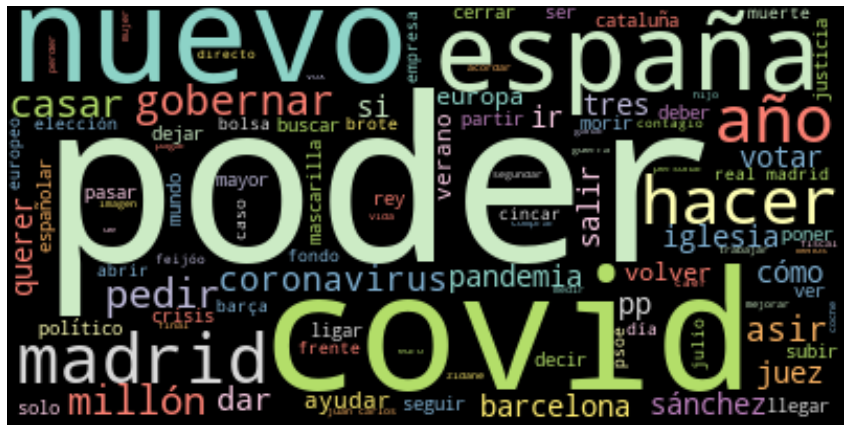

In [78]:
text = " ".join(str(each) for each in df_reales_v.Texto_2.unique())
wordcloud = WordCloud(max_words=100,colormap='Set3', background_color="black", random_state=123).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

#### 4.1.2. Análisis de frecuencias Noticias Reales

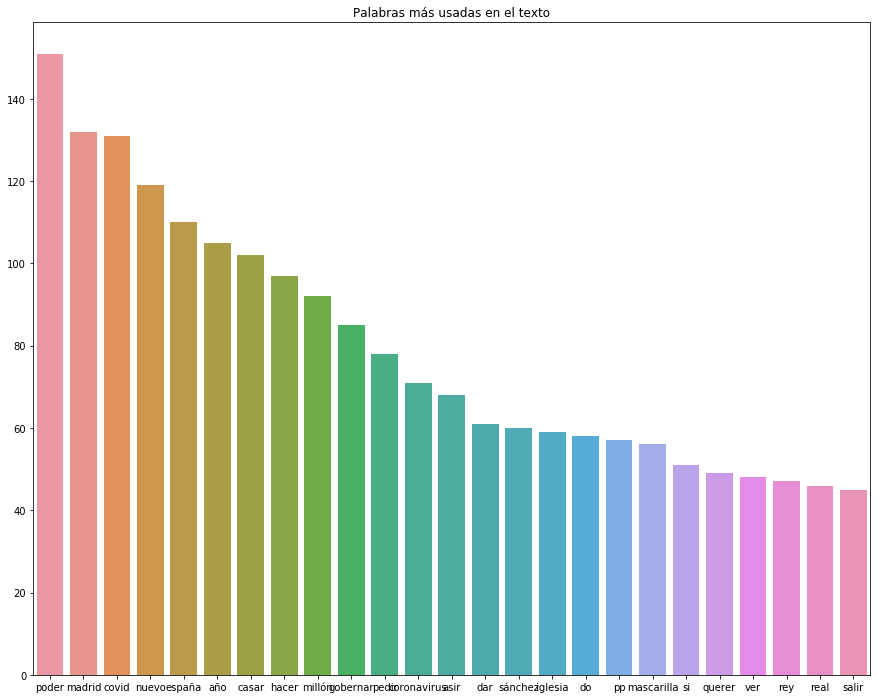

In [79]:
all_text = [text for text in df_reales_v['Texto_2']]
all_text_clean = ' '.join(all_text).split()
all_text_clean = [word for word in all_text_clean if word != '\'s']
all_text_counts = Counter(all_text_clean)
all_text_common_words = [word[0] for word in all_text_counts.most_common(25)]
all_text_common_counts = [word[1] for word in all_text_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=all_text_common_words, y=all_text_common_counts)
plt.title('Palabras más usadas en el texto')
plt.show()

### 4.2.  Noticias Falsas

In [80]:
df_falsas_v = df[df['Target']==1]

#### 4.2.1. Wordcloud

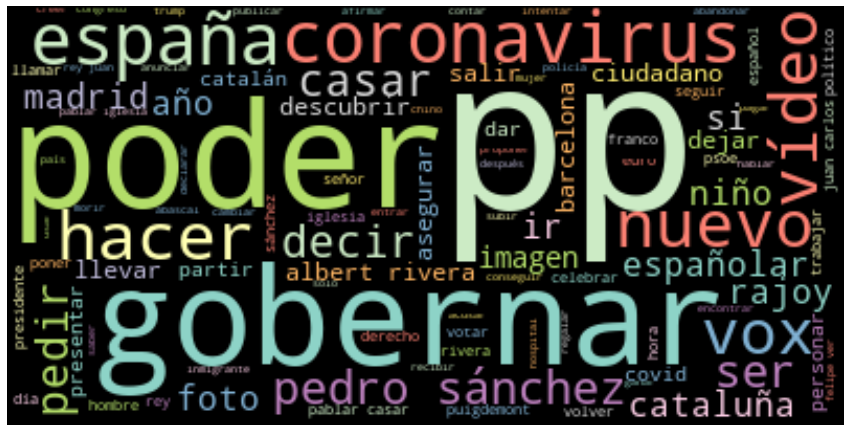

In [81]:
text = " ".join(str(each) for each in df_falsas_v.Texto_2.unique())
wordcloud = WordCloud(max_words=100,colormap='Set3', background_color="black", random_state=123).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

#### 4.2.2. Análisis de frecuencias Noticias Falsas

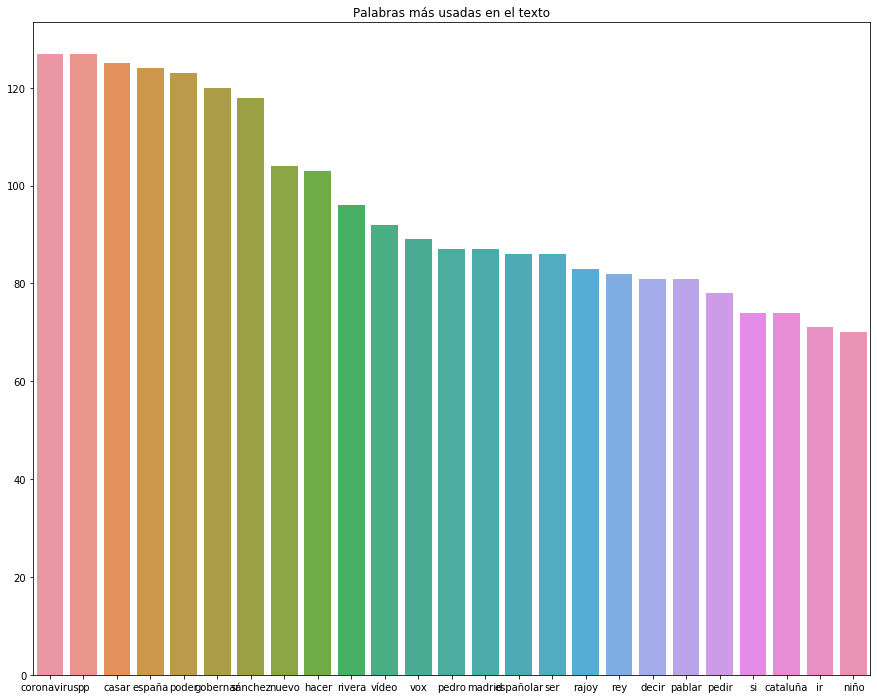

In [82]:
all_text = [text for text in df_falsas_v['Texto_2']]
all_text_clean = ' '.join(all_text).split()
all_text_clean = [word for word in all_text_clean if word != '\'s']
all_text_counts = Counter(all_text_clean)
all_text_common_words = [word[0] for word in all_text_counts.most_common(25)]
all_text_common_counts = [word[1] for word in all_text_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=all_text_common_words, y=all_text_common_counts)
plt.title('Palabras más usadas en el texto')
plt.show()

## 5. Modelos

### 5.1. Muestreo estratificaco

In [83]:
#X = df.Texto #Texto sin lematizar ni sin convertir a raíces
X = df.Texto_2 #Texto tras lematizar
#X = df.Texto_3 #Texto tras convertir a raíces
#X = df.Texto_4 #Texto tras lematizar y convertir a raíces

y = df.Target

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y)

Comprobamos que el muestreo es estratificado por la variable target

In [85]:
y_train.value_counts()

1    2550
0    2550
Name: Target, dtype: int64

In [86]:
y_test.value_counts()

1    638
0    638
Name: Target, dtype: int64

### 5.2. Métricas de análisis

In [87]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)
    plt.style.use('classic')

### 5.3. Desarrollo de modelos

#### 5.3.1. Naive Bayes

matriz de confusión
[[498 140]
 [104 534]]
accuracy
0.8087774294670846
precision
0.7922848664688428
recall
0.8369905956112853
f1
0.8140243902439024
AUC
0.8087774294670846


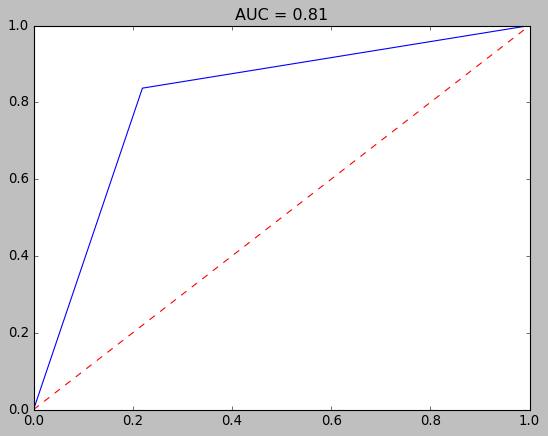

In [88]:
tfidf_vect = TfidfVectorizer()
algoritmo = MultinomialNB()

modelo1 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo1.predict(tfidf_vect.transform(X_test))
plt.style.use('classic')
saca_metricas(y_test, y_pred)

#### 5.3.2. Regresión Logística

matriz de confusión
[[522 116]
 [143 495]]
accuracy
0.7970219435736677
precision
0.8101472995090017
recall
0.7758620689655172
f1
0.7926341072858286
AUC
0.7970219435736677


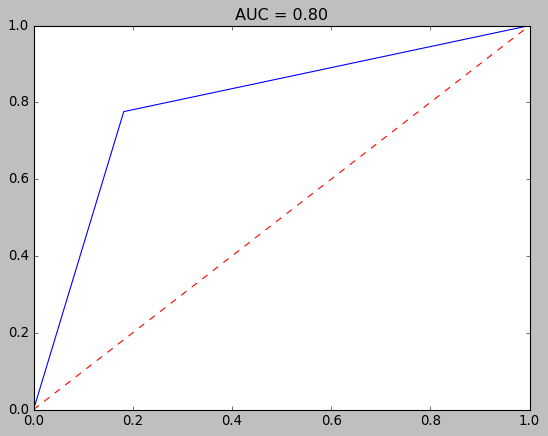

In [89]:
tfidf_vect = TfidfVectorizer()
algoritmo = LogisticRegression()

modelo2 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo2.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.3. Support Vector Classifier

matriz de confusión
[[527 111]
 [130 508]]
accuracy
0.8111285266457681
precision
0.8206785137318255
recall
0.7962382445141066
f1
0.8082736674622117
AUC
0.8111285266457681


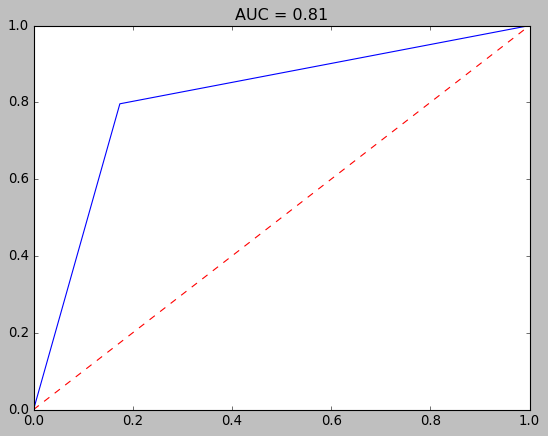

In [90]:
tfidf_vect = TfidfVectorizer()
algoritmo = SVC(probability=True)

modelo3 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo3.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.4. Árbol de decisión

matriz de confusión
[[456 182]
 [171 467]]
accuracy
0.7233542319749217
precision
0.7195685670261941
recall
0.731974921630094
f1
0.7257187257187258
AUC
0.7233542319749217


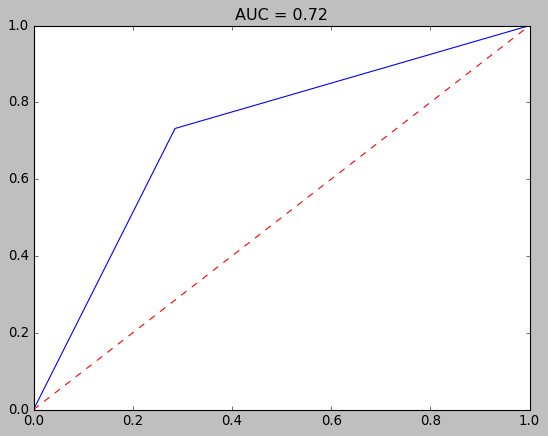

In [91]:
tfidf_vect = TfidfVectorizer()
algoritmo = DecisionTreeClassifier(random_state=42)

modelo4 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo4.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.5. Random Forest

matriz de confusión
[[528 110]
 [172 466]]
accuracy
0.7789968652037618
precision
0.8090277777777778
recall
0.7304075235109718
f1
0.7677100494233937
AUC
0.7789968652037618


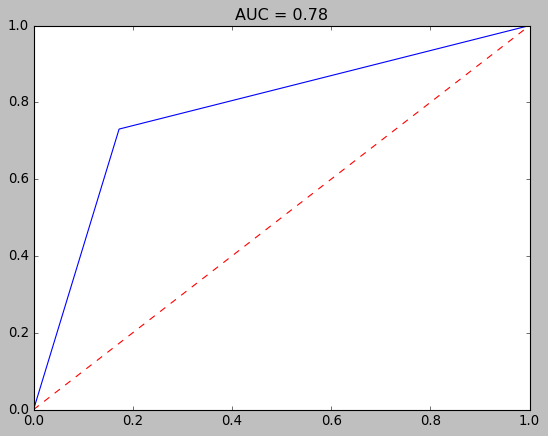

In [92]:
tfidf_vect = TfidfVectorizer()
algoritmo = RandomForestClassifier(random_state=42)

modelo5 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo5.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.6. XGBClassifier

matriz de confusión
[[529 109]
 [234 404]]
accuracy
0.7311912225705329
precision
0.7875243664717348
recall
0.6332288401253918
f1
0.7019982623805386
AUC
0.7311912225705329


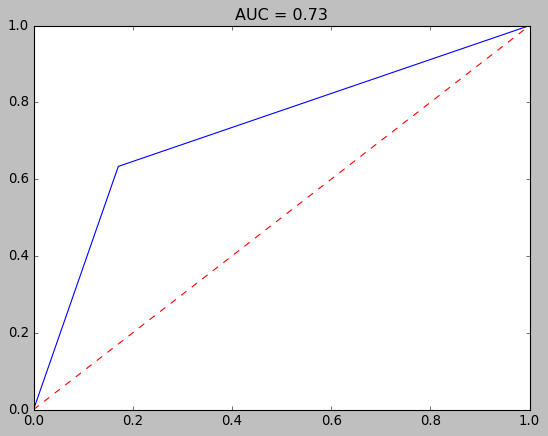

In [93]:
tfidf_vect = TfidfVectorizer()
algoritmo = XGBClassifier(random_state=42)

modelo6 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo6.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.7. Red Neuronal Long Short-Term Memory (LSTM)

Se tokenizan las muestras

In [94]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

Se prepara la red neuronal

In [95]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [96]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Se ejecuta el modelo

In [97]:
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

Train on 4080 samples, validate on 1020 samples
Epoch 1/5
4080/4080 [==============================] - 9s 2ms/step - loss: 0.6536 - accuracy: 0.6127 - val_loss: 0.5544 - val_accuracy: 0.7108
Epoch 2/5
4080/4080 [==============================] - 8s 2ms/step - loss: 0.4455 - accuracy: 0.7983 - val_loss: 0.4839 - val_accuracy: 0.7775
Epoch 3/5
4080/4080 [==============================] - 8s 2ms/step - loss: 0.3708 - accuracy: 0.8395 - val_loss: 0.4920 - val_accuracy: 0.7843
Epoch 4/5
4080/4080 [==============================] - 8s 2ms/step - loss: 0.3447 - accuracy: 0.8544 - val_loss: 0.4954 - val_accuracy: 0.7755
Epoch 5/5
4080/4080 [==============================] - 8s 2ms/step - loss: 0.3332 - accuracy: 0.8593 - val_loss: 0.5085 - val_accuracy: 0.7794


Evaluación de la muestra Test

In [98]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [99]:
accr = model.evaluate(test_sequences_matrix,y_test)

1276/1276 [==============================] - 1s 689us/step


In [100]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.549
  Accuracy: 0.752


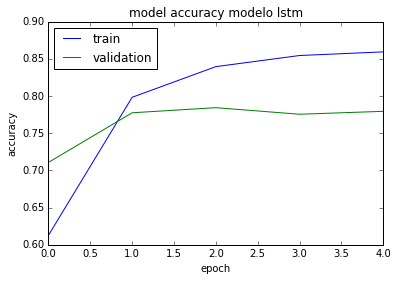

In [101]:
%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

## 6. Validación Cruzada

### 6.1. Naive Bayes

In [102]:
tfidf_vect = TfidfVectorizer()
algoritmo = MultinomialNB()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores1 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores1 = pd.DataFrame(scores1, columns=['Accuracy'])
scores1.loc["Media"] = scores1.mean()
scores1.loc["Desv.Típica"] = scores1.std()
scores1

,Accuracy
0,0.798039
1,0.782353
2,0.810784
3,0.799020
4,0.778431
Media,0.793725
Desv.Típica,0.011840


### 6.2. Regresión Logística

In [103]:
tfidf_vect = TfidfVectorizer()
algoritmo = LogisticRegression()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores2 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores2 = pd.DataFrame(scores2, columns=['Accuracy'])
scores2.loc["Media"] = scores2.mean()
scores2.loc["Desv.Típica"] = scores2.std()
scores2

,Accuracy
0,0.795098
1,0.776471
2,0.795098
3,0.789216
4,0.799020
Media,0.790980
Desv.Típica,0.007902


###  6.3. Support Vector Classifier

In [104]:
tfidf_vect = TfidfVectorizer()
algoritmo = SVC(probability=True)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores3 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores3 = pd.DataFrame(scores3, columns=['Accuracy'])
scores3.loc["Media"] = scores3.mean()
scores3.loc["Desv.Típica"] = scores3.std()
scores3

,Accuracy
0,0.800980
1,0.776471
2,0.802941
3,0.793137
4,0.806863
Media,0.796078
Desv.Típica,0.010775


### 6.4. Árbol de decisión

In [105]:
tfidf_vect = TfidfVectorizer()
algoritmo = DecisionTreeClassifier(random_state=42)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores4 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores4 = pd.DataFrame(scores4, columns=['Accuracy'])
scores4.loc["Media"] = scores4.mean()
scores4.loc["Desv.Típica"] = scores4.std()
scores4

,Accuracy
0,0.691176
1,0.699020
2,0.690196
3,0.698039
4,0.709804
Media,0.697647
Desv.Típica,0.007032


### 6.5. Random Forest

In [106]:
tfidf_vect = TfidfVectorizer()
algoritmo = RandomForestClassifier()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores5 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores5 = pd.DataFrame(scores5, columns=['Accuracy'])
scores5.loc["Media"] = scores5.mean()
scores5.loc["Desv.Típica"] = scores5.std()
scores5

,Accuracy
0,0.747059
1,0.723529
2,0.756863
3,0.753922
4,0.750000
Media,0.746275
Desv.Típica,0.011853


### 6.6.  XGBClassifier

In [107]:
tfidf_vect = TfidfVectorizer()
algoritmo = XGBClassifier(random_state=42)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores6 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores6 = pd.DataFrame(scores6, columns=['Accuracy'])
scores6.loc["Media"] = scores6.mean()
scores6.loc["Desv.Típica"] = scores6.std()
scores6

,Accuracy
0,0.714706
1,0.699020
2,0.724510
3,0.726471
4,0.740196
Media,0.720980
Desv.Típica,0.013664


## 7. Ajuste de hiperparámetros

Realizamos un estudio para la selección de los hiperparámetros que mejor optimicen cada uno de los modelos, ofreciendo diferentes opciones y considerando validación cruzada repetida.

###  7.1. Naive Bayes

Definición del modelo

In [108]:
nbayes = MultinomialNB()

Definición de los hiperparámetros

In [109]:
alpha = [0, 0.5, 1, 2]

fit_prior = [True, False]

hyperparameters = dict(alpha=alpha, fit_prior=fit_prior)
hyperparameters

{'alpha': [0, 0.5, 1, 2], 'fit_prior': [True, False]}

In [110]:
clf = GridSearchCV(nbayes, hyperparameters, scoring='roc_auc', cv=5, verbose=0) 

In [111]:
tfidf_vect = TfidfVectorizer()
best_model1 = clf.fit(tfidf_vect.fit_transform(X_train), y_train)

In [112]:
best_model1.best_estimator_.get_params()

{'alpha': 0.5, 'class_prior': None, 'fit_prior': True}

matriz de confusión
[[502 136]
 [107 531]]
accuracy
0.8095611285266457
precision
0.7961019490254873
recall
0.8322884012539185
f1
0.8137931034482758
AUC
0.8095611285266457


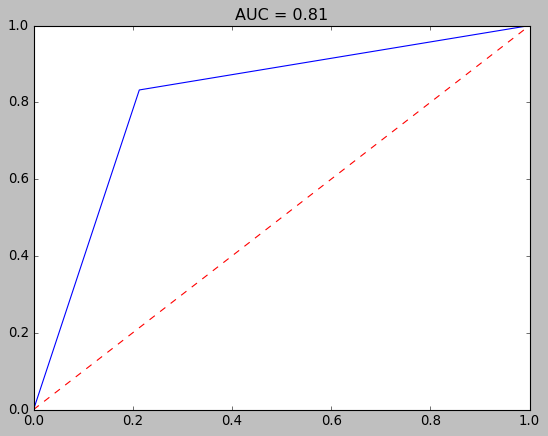

In [113]:
y_pred = best_model1.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

###  7.2. Regresión Logística

Definición del modelo

In [114]:
logistic = LogisticRegression()

Definición de los hiperparámetros para la Regresión Logística

In [115]:
penalty = ['l1', 'l2']

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

hyperparameters = dict(C=C, penalty=penalty)

Definición de la función GridSearch con cross-validation de 5 muestras

In [116]:
clf = GridSearchCV(logistic, hyperparameters, scoring='roc_auc', cv=5, verbose=0) 

Ejecución del GridSearch

In [117]:
tfidf_vect = TfidfVectorizer()
best_model2 = clf.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [118]:
best_model2.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Predicción

matriz de confusión
[[521 117]
 [135 503]]
accuracy
0.8025078369905956
precision
0.8112903225806452
recall
0.7884012539184952
f1
0.7996820349761525
AUC
0.8025078369905956


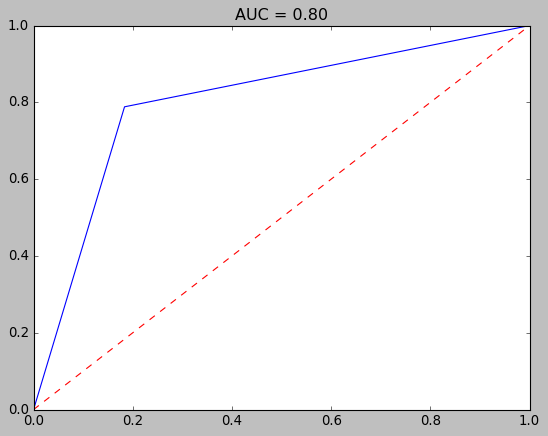

In [119]:
y_pred = best_model2.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.3. Support Vector Classififier

Definición del modelo

In [120]:
svm = SVC(probability=True)

Hiperparámetros

In [121]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100]}]

Ejecución Gridsearch

In [122]:
tfidf_vect = TfidfVectorizer()
grid = GridSearchCV(svm, tuned_parameters, scoring='roc_auc', cv=5) 
best_model3 = grid.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del modelo

In [123]:
best_model3.best_estimator_.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Predicción con el mejor modelo obtenido

matriz de confusión
[[530 108]
 [126 512]]
accuracy
0.8166144200626959
precision
0.8258064516129032
recall
0.8025078369905956
f1
0.8139904610492845
AUC
0.8166144200626959


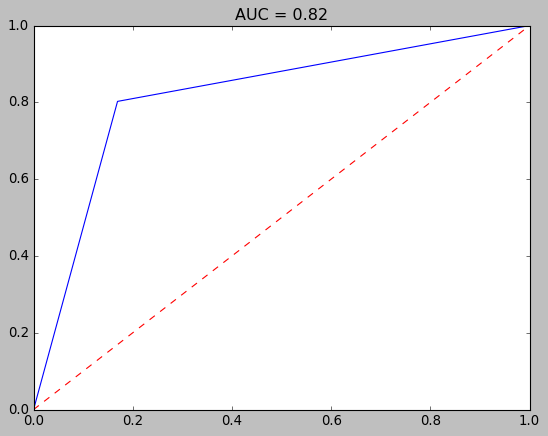

In [124]:
y_pred = best_model3.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.4. Decission Tree

Definición del modelo

In [125]:
dectree = DecisionTreeClassifier(random_state=42)

Hiperparámetros

In [126]:
parametros = {'max_depth': [None, 1, 3, 5, 10],
        'min_samples_split': [None, 1, 2],
        'max_features': [None, 1, 3, 5, 10],
        'random_state': [42]
        }

Ejecución del Gridsearch

In [127]:
tfidf_vect = TfidfVectorizer()
grid = GridSearchCV(dectree, parametros, scoring='roc_auc', cv=5) 
best_model4 = grid.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [128]:
best_model4.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

Predicción con el mejor modelo obtenido

matriz de confusión
[[456 182]
 [171 467]]
accuracy
0.7233542319749217
precision
0.7195685670261941
recall
0.731974921630094
f1
0.7257187257187258
AUC
0.7233542319749217


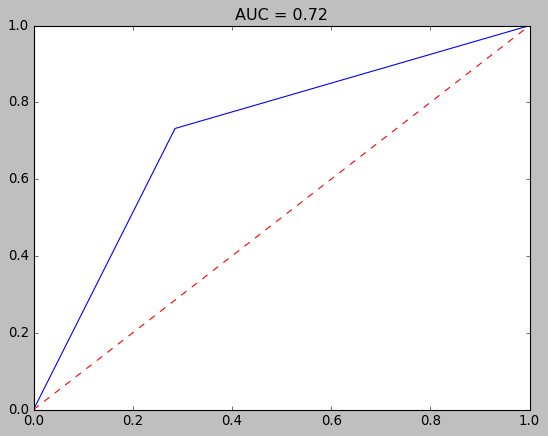

In [129]:
y_pred = best_model4.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.5. Random Forest

Algoritmo Random Forest

In [130]:
rfc=RandomForestClassifier(random_state=42)

Hiperparámetros

In [131]:
parametros = {'max_depth': [None, 1, 3, 8],
        'min_samples_split': [None, 1, 2],
        'max_features': [None, 1, 3, 8],
        'random_state': [42]
        }

Ejecución del Gridsearch

In [132]:
tfidf_vect = TfidfVectorizer()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=parametros, scoring='roc_auc', cv=5)
best_model5 = CV_rfc.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [133]:
best_model5.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Predicción

matriz de confusión
[[559  79]
 [181 457]]
accuracy
0.7962382445141066
precision
0.8526119402985075
recall
0.7163009404388715
f1
0.7785349233390119
AUC
0.7962382445141066


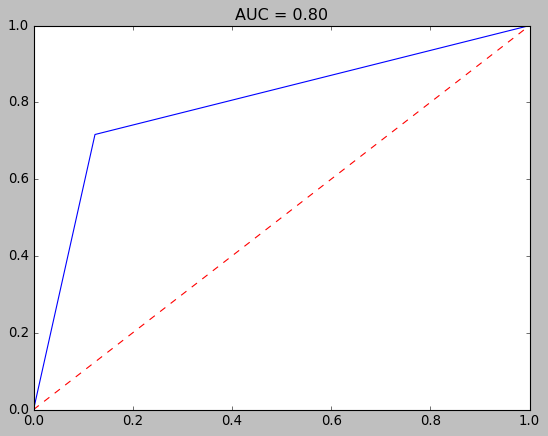

In [134]:
y_pred = best_model5.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.6. XGBClassifier

Definición del modelo

In [135]:
xgboost =XGBClassifier(random_state=42)

Hiperparámetros

In [136]:
params = {
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1],
        'max_depth': [3, 4, 5]
        }

In [137]:
tfidf_vect = TfidfVectorizer()
CV_rfc = GridSearchCV(estimator=xgboost, param_grid=params, scoring='roc_auc', cv= 5)
best_model6 = CV_rfc.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del modelo

In [138]:
best_model6.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 2,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None}

Predicción del mejor modelo

matriz de confusión
[[529 109]
 [233 405]]
accuracy
0.731974921630094
precision
0.7879377431906615
recall
0.6347962382445141
f1
0.7031250000000001
AUC
0.731974921630094


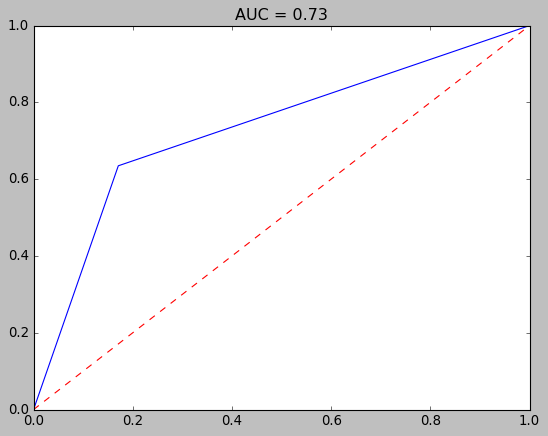

In [139]:
y_pred = best_model6.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.7. Red neuronal LSTM

No es posible realizar GridSearch para la red neuronal. Por ello, se probarán distintas opciones de ejecución de los parámetros de la red neuronal para averiguar qué opciones darían mejores resultados.

En primer lugar tokenizamos la base de datos

In [140]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#### 7.7.1. Modificación de la densidad de las capas

Incremento de la densidad de las capas

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
FC1 (Dense)                  (None, 512)               66048     
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 513 

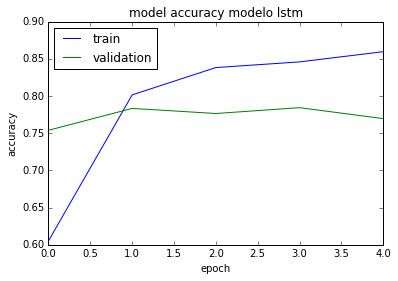

In [141]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(512,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

Decremento de la densidad de las capas

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 128)               4224      
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129 

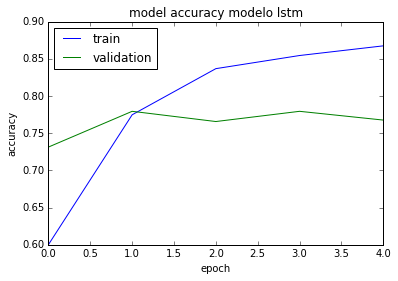

In [142]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.2. Modificación de batch size

Incremento de bacth size

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

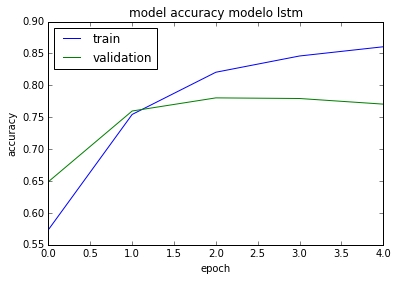

In [143]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=100,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

Decremento de bacth size

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

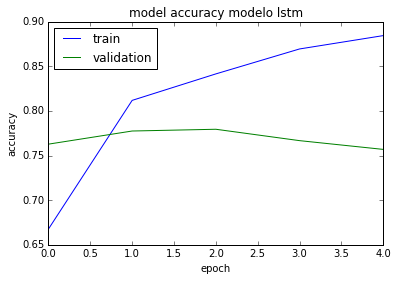

In [144]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=10,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.3. Modificación de epoch

Incremento de epoch

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

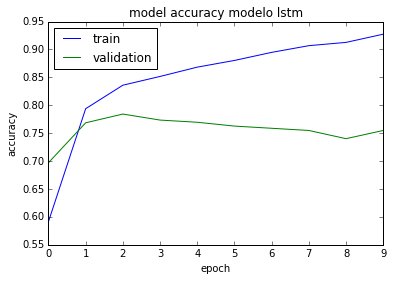

In [145]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=10,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')


Decremento de epoch

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

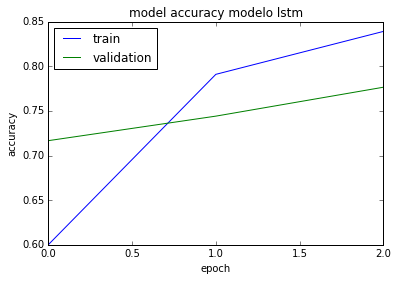

In [146]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=3,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.4. Modificación de múltiples parámetros

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 128)               4224      
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129 

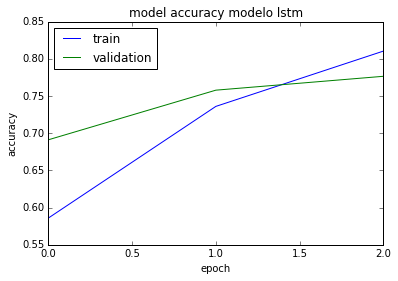

In [147]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=100,epochs=3,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')


## 8. Guardamos el modelo final

Guardamos el modelo

In [148]:
filename = 'modelo_textos_cortos.sav'
pickle.dump(best_model3, open(filename, 'wb'))

Probamos a cargar el modelo

matriz de confusión
[[530 108]
 [126 512]]
accuracy
0.8166144200626959
precision
0.8258064516129032
recall
0.8025078369905956
f1
0.8139904610492845
AUC
0.8166144200626959


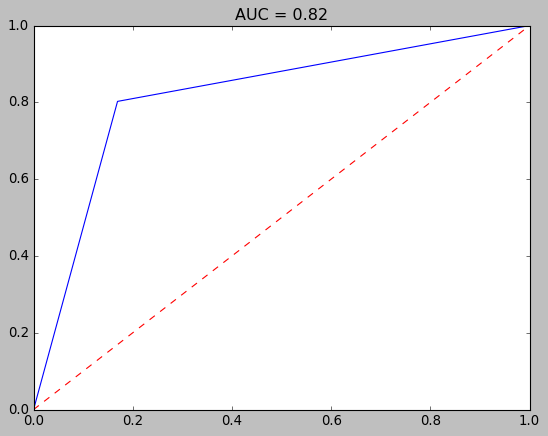

In [149]:
loaded_model = pickle.load(open('modelo_textos_cortos.sav', 'rb'))
y_pred = loaded_model.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

## 9. Predicción noticias freelance

Cargamos el modelo

In [150]:
loaded_model = pickle.load(open('modelo_textos_cortos.sav', 'rb'))

Importamos los datasets de noticias freelance. La presente ejecución se ha llevado a cabo con los siguientes archivos:

* freelance_19072020
* freelance_20072020

In [151]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/free' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_fake = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_fake)

df_free_original = pd.concat(li, axis=0, ignore_index=True)

Analizamos las características del dataset

In [152]:
df_free_original.shape

(256, 10)

In [153]:
df_free_original.head(5)

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL
0,0,new_1,Menéame,Nueva Democracia Boliviana,Berlinguer,NaN,NaN,Tras 7 meses y medio de la llegada de los libe...,NaN,https://www.meneame.net/m/Art%C3%ADculos/nueva...
1,1,new_2,Menéame,Errores de concepto en el teletrabajo,Feindesland,NaN,NaN,Cuando se extiende un nuevo modo de hacer las ...,NaN,https://www.meneame.net/m/Art%C3%ADculos/error...
2,2,new_3,Menéame,Teletrabajo. Apertura de la competencia labora...,luigicomenccini,NaN,NaN,Para ver las repercusiones a medio plazo de la...,NaN,https://www.meneame.net/m/LuchaDClases/teletra...
3,3,new_4,Menéame,Debate para fijar los criterios a seguir en no...,Jakeukalane,NaN,NaN,De un tiempo a esta parte hay varios medios qu...,NaN,https://www.meneame.net/m/Art%C3%ADculos/crite...
4,4,new_5,Menéame,Pues yo creo que está subiendo el nivel,Feindesland,NaN,NaN,Nos quejamos siempre de nuestra propia decaden...,NaN,https://www.meneame.net/m/Art%C3%ADculos/pues-...


Analizamos si hay títulos a missing

In [154]:
df_free_original[df_free_original["Título"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL


Nos quedamos únicamente con el titular

In [155]:
df_free = df_free_original[["Título"]]

Llamamos a la variable "Texto" y quitamos espacios excesivos

In [156]:
df_free = df_free.rename({'Título': 'Texto'}, axis=1)

In [157]:
df_free.head(5)

,Texto
0,Nueva Democracia Boliviana
1,Errores de concepto en el teletrabajo
2,Teletrabajo. Apertura de la competencia labora...
3,Debate para fijar los criterios a seguir en no...
4,Pues yo creo que está subiendo el nivel


In [158]:
df_free["Texto"] = df_free["Texto"].astype(str)
df_free["Texto"] = df_free["Texto"].str.split()
df_free['Texto'] = df_free['Texto'].apply(lambda x: ','.join(map(str, x)))
df_free['Texto'] = df_free['Texto'].str.replace( ",", ' ')

In [159]:
df_free.head(5)

,Texto
0,Nueva Democracia Boliviana
1,Errores de concepto en el teletrabajo
2,Teletrabajo. Apertura de la competencia labora...
3,Debate para fijar los criterios a seguir en no...
4,Pues yo creo que está subiendo el nivel


Eliminamos duplicados

In [160]:
df_free = df_free.drop_duplicates()

In [161]:
df_free.shape

(92, 1)

In [162]:
df_free.head(5)

,Texto
0,Nueva Democracia Boliviana
1,Errores de concepto en el teletrabajo
2,Teletrabajo. Apertura de la competencia labora...
3,Debate para fijar los criterios a seguir en no...
4,Pues yo creo que está subiendo el nivel


Llevamos a cabo las mismas tareas de pre-procesado que las realizadas en el desarrollo del modelo

In [163]:
#Eliminación de números
df_free["Texto"] = df_free["Texto"].apply(lambda x: elimina_numeros(x))

#Transformación a minúscula
df_free["Texto"] = df_free["Texto"].str.lower()

#Signos de puntuación
df_free["Texto"] = df_free['Texto'].str.replace('[{}]'.format(string.punctuation), '')
df_free['Texto'] = df_free['Texto'].str.replace('"', '')
df_free['Texto'] = df_free['Texto'].str.replace("\n", '')
df_free['Texto'] = df_free['Texto'].str.replace("•", '')
df_free['Texto'] = df_free['Texto'].str.replace("“", '')
df_free['Texto'] = df_free['Texto'].str.replace( "”", '')
df_free['Texto'] = df_free['Texto'].str.replace( '–', '')
df_free['Texto'] = df_free['Texto'].str.replace( '«', '')
df_free['Texto'] = df_free['Texto'].str.replace( '»', '')

#URL del texto
df_free["Texto"] = df_free["Texto"].apply(lambda x: remove_URL(x))

#Stopwords
df_free["Texto"] = df_free["Texto"].str.split()
df_free['Texto']= df_free['Texto'].apply(lambda x: [item for item in x if item not in stop])
df_free['Texto'] = df_free['Texto'].apply(lambda x: ','.join(map(str, x)))
df_free['Texto'] = df_free['Texto'].str.replace( ",", ' ')

#Lematización
df_free["Texto"] = df_free["Texto"].apply(lambda x: lematizar(x))
df_free['Texto'] = df_free['Texto'].apply(lambda x: ','.join(map(str, x)))
df_free['Texto'] = df_free['Texto'].str.replace( ",", ' ')

In [164]:
df_free.head(5)

,Texto
0,nuevo democracia boliviano
1,error concepto teletrabajo
2,teletrabajo apertura competencia laboral deslo...
3,debatir fijar criterio seguir noticiar requeri...
4,pues creer subir nivel


Seleccionamos la variable a predecir

In [165]:
X_free = df_free.iloc[:]

In [166]:
X_free.head(5)

,Texto
0,nuevo democracia boliviano
1,error concepto teletrabajo
2,teletrabajo apertura competencia laboral deslo...
3,debatir fijar criterio seguir noticiar requeri...
4,pues creer subir nivel


Realizamos la predicción

In [167]:
prediccion = pd.DataFrame(loaded_model.predict(tfidf_vect.transform(X_free.Texto)), columns=["Pred"])
prediccion = prediccion.reset_index()
prediccion

,index,Pred
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
87,87,0
88,88,0
89,89,0
90,90,0


Analizamos cuántos valores saldrían como fake news y cuántos como noticias reales

In [168]:
prediccion["Pred"].value_counts()

0    60
1    32
Name: Pred, dtype: int64

Calculamos la probabilidad asociada a ser noticia real y la asociada a noticia fake

In [169]:
prediccion_prob = pd.DataFrame(loaded_model.predict_proba(tfidf_vect.transform(X_free.Texto)), 
                               columns=["Prob Real", "Prob Fake"])
prediccion_prob = prediccion_prob.reset_index()
prediccion_prob

,index,Prob Real,Prob Fake
0,0,0.626623,0.373377
1,1,0.812919,0.187081
2,2,0.954788,0.045212
3,3,0.610425,0.389575
4,4,0.063873,0.936127
...,...,...,...
87,87,0.894481,0.105519
88,88,0.643838,0.356162
89,89,0.862425,0.137575
90,90,0.990135,0.009865


 Cruzamos la información para tener la información en una única tabla

In [170]:
df_free_original = df_free_original.reset_index()
analisis_fake = pd.merge(prediccion, df_free_original, on='index', how='inner')
analisis_fake = pd.merge(analisis_fake, prediccion_prob, on='index', how='inner')

In [171]:
analisis_fake[["index", "Título", "Pred", "Prob Real", "Prob Fake"]].head(10)

,index,Título,Pred,Prob Real,Prob Fake
0,0,Nueva Democracia Boliviana,0,0.626623,0.373377
1,1,Errores de concepto en el teletrabajo,0,0.812919,0.187081
2,2,Teletrabajo. Apertura de la competencia labora...,0,0.954788,0.045212
3,3,Debate para fijar los criterios a seguir en no...,0,0.610425,0.389575
4,4,Pues yo creo que está subiendo el nivel,1,0.063873,0.936127
5,5,¿Odias la informática? Entra a trabajar en pri...,1,0.163243,0.836757
6,6,"Monarquía, sucesión y transitividad",0,0.872715,0.127285
7,7,Al fin estoy de acuerdo con un ranking sobre l...,0,0.487435,0.512565
8,8,Portal (Super Ficción–75),1,0.250090,0.749910
9,9,"No, si no te devuelven el dinero en una compra...",0,0.670106,0.329894
